<a href="https://colab.research.google.com/github/lmoroney/tfbook/blob/master/chapter11/rnn_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

min = np.min(series)
max = np.max(series)
series -= min
series /= max
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000



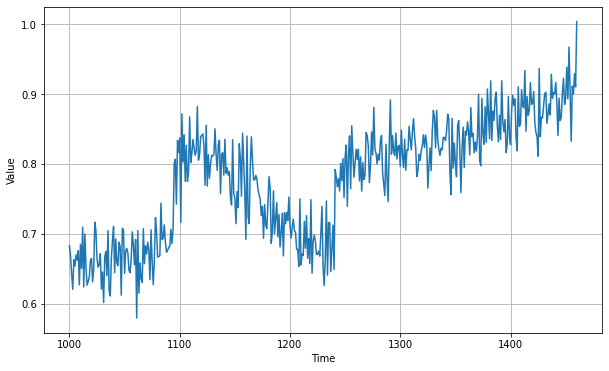

In [62]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
#plot_series(time_train, x_train)

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [64]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 15
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
  tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True, dropout=0.1, recurrent_dropout=0.5),
  tf.keras.layers.GRU(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.5, activation='relu'), 
  tf.keras.layers.Dense(1),
])


model.compile(loss='mae', optimizer=tf.keras.optimizers.RMSprop())
history = model.fit(dataset, epochs=25,  verbose=1)

Epoch 1/25
31/31 [==============================] - 5s 173ms/step - loss: 0.1210
Epoch 2/25
31/31 [==============================] - 2s 59ms/step - loss: 0.0844
Epoch 3/25
31/31 [==============================] - 2s 59ms/step - loss: 0.0731
Epoch 4/25
31/31 [==============================] - 2s 59ms/step - loss: 0.0738
Epoch 5/25
31/31 [==============================] - 2s 59ms/step - loss: 0.0639
Epoch 6/25
31/31 [==============================] - 2s 58ms/step - loss: 0.0608
Epoch 7/25
31/31 [==============================] - 2s 59ms/step - loss: 0.0596
Epoch 8/25
31/31 [==============================] - 2s 58ms/step - loss: 0.0585
Epoch 9/25
31/31 [==============================] - 2s 59ms/step - loss: 0.0579
Epoch 10/25
31/31 [==============================] - 2s 58ms/step - loss: 0.0560
Epoch 11/25
31/31 [==============================] - 2s 60ms/step - loss: 0.0526
Epoch 12/25
31/31 [==============================] - 2s 60ms/step - loss: 0.0569
Epoch 13/25
31/31 [=================

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:,0]

In [71]:
print(forecast)

[[0.55044514]
 [0.6351648 ]
 [0.6154617 ]
 [0.5810233 ]
 [0.5892866 ]
 [0.595481  ]
 [0.52588254]
 [0.58197635]
 [0.5687754 ]
 [0.5592489 ]
 [0.58225244]
 [0.6493076 ]
 [0.61243016]
 [0.57448435]
 [0.611166  ]
 [0.63823766]
 [0.6233807 ]
 [0.5962078 ]
 [0.5743729 ]
 [0.61750597]
 [0.60822076]
 [0.6247704 ]
 [0.6168871 ]
 [0.6306885 ]
 [0.5806348 ]
 [0.6403032 ]
 [0.604777  ]
 [0.6659829 ]
 [0.57764685]
 [0.65584517]
 [0.606673  ]
 [0.5802333 ]
 [0.58598197]
 [0.59162235]
 [0.6158113 ]
 [0.6194557 ]
 [0.58503395]
 [0.60292023]
 [0.6735723 ]
 [0.6604547 ]
 [0.6190909 ]
 [0.60682815]
 [0.60993   ]
 [0.6262471 ]
 [0.5747029 ]
 [0.59935385]
 [0.55549645]
 [0.6213101 ]
 [0.62978566]
 [0.59412324]
 [0.66089934]
 [0.5716895 ]
 [0.5647095 ]
 [0.6186498 ]
 [0.64571726]
 [0.66702247]
 [0.5983091 ]
 [0.64825094]
 [0.6126972 ]
 [0.60890555]
 [0.6434229 ]
 [0.63642716]
 [0.5660415 ]
 [0.66428995]
 [0.66164124]
 [0.5974576 ]
 [0.6306575 ]
 [0.6343365 ]
 [0.6273101 ]
 [0.60184205]
 [0.5984845 ]
 [0.61

160.70773


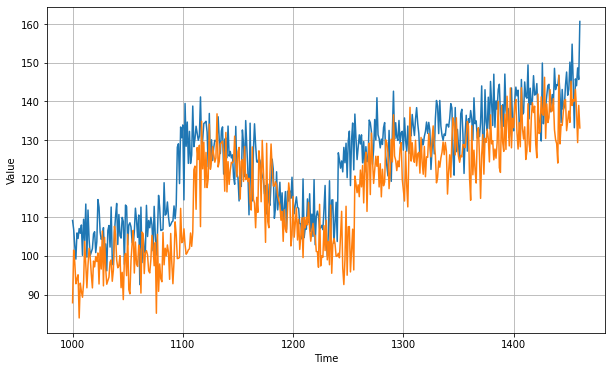

In [72]:
plt.figure(figsize=(10, 6))

#plot_series(time_valid, x_valid)
#plot_series(time_valid, forecast)

scaled_xvalid=x_valid*max
scaled_xvalid=scaled_xvalid+min
scaled_forecast=forecast*max
scaled_forecast=scaled_forecast+min

plot_series(time_valid, scaled_xvalid)
plot_series(time_valid, scaled_forecast)

print(max)


In [73]:
tf.keras.metrics.mean_absolute_error(scaled_xvalid, scaled_forecast).numpy()

array([36.542233 , 23.10792  , 26.133461 , 31.629053 , 30.306828 ,
       29.31567  , 40.489635 , 31.47655  , 33.59642  , 35.127403 ,
       31.43237  , 21.059227 , 26.61197  , 32.678955 , 26.812462 ,
       22.652853 , 24.89571  , 29.19937  , 32.69686  , 25.812057 ,
       27.281603 , 24.680725 , 25.909355 , 23.778162 , 31.691212 ,
       22.348368 , 27.830246 , 18.868093 , 32.170715 , 20.165243 ,
       27.528187 , 31.755455 , 30.835606 , 29.93309  , 26.078495 ,
       25.506525 , 30.987303 , 28.12605  , 17.988142 , 19.563961 ,
       25.563623 , 27.503462 , 27.009306 , 24.45284  , 32.64383  ,
       28.695961 , 35.730453 , 25.216925 , 23.914911 , 29.532915 ,
       19.506765 , 33.128105 , 34.249847 , 25.632668 , 21.564735 ,
       18.741959 , 28.863132 , 21.20718  , 26.569809 , 27.172504 ,
       21.893179 , 22.920713 , 34.035774 , 19.07603  , 19.411543 ,
       28.99939  , 23.782835 , 23.23122  , 24.290316 , 28.297827 ,
       28.835064 , 25.48076  , 19.756535 , 22.541138 , 26.9847